# COVID-19 Dataset Analysis
## RNN: LSTM을 이용한 COVID-19 감염자 예측
- 시계열 데이터 처리를 이용하여 COVID-19 감염자를 예측하고자 함
- Dataset: KCDC, https://github.com/jooeungen/coronaboard_kr

         date  confirmed  death  released   tested  negative
0    20200121          1      0         0        1         0
1    20200122          1      0         0        1         0
2    20200123          1      0         0        1         0
3    20200124          2      0         0        2         0
4    20200125          2      0         0        2         0
..        ...        ...    ...       ...      ...       ...
152  20200621      12421    280     10868  1176463   1143971
153  20200622      12438    280     10881  1182066   1150225
154  20200623      12484    281     10908  1196012   1161250
155  20200624      12535    281     10930  1208597   1175817
156  20200625      12563    282     10974  1220478   1189015

[157 rows x 6 columns]


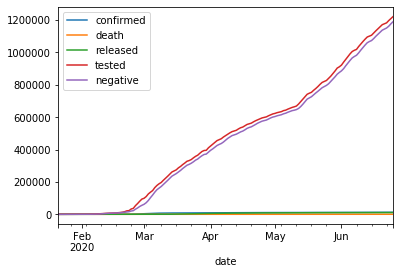

In [73]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, LSTM

from sklearn.model_selection import train_test_split


df = pd.read_csv("kr_daily.csv")

print(df)
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')
df = df.set_index('date')

df.plot()

In [74]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scale_cols = ['confirmed', 'death', 'released', 'tested', 'negative']
df_scaled = scaler.fit_transform(df[scale_cols])

df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

print(df_scaled)

     confirmed     death  released        tested  negative
0     0.000000  0.000000  0.000000  0.000000e+00  0.000000
1     0.000000  0.000000  0.000000  0.000000e+00  0.000000
2     0.000000  0.000000  0.000000  0.000000e+00  0.000000
3     0.000080  0.000000  0.000000  8.193518e-07  0.000000
4     0.000080  0.000000  0.000000  8.193518e-07  0.000000
..         ...       ...       ...           ...       ...
152   0.988696  0.992908  0.990341  9.639362e-01  0.962117
153   0.990049  0.992908  0.991525  9.685271e-01  0.967376
154   0.993711  0.996454  0.993986  9.799537e-01  0.976649
155   0.997771  0.996454  0.995991  9.902653e-01  0.988900
156   1.000000  1.000000  1.000000  1.000000e+00  1.000000

[157 rows x 5 columns]


In [145]:
TEST_SIZE = 20

In [146]:
train = df_scaled[:-TEST_SIZE]
test = df_scaled[-TEST_SIZE:]

In [171]:
def make_dataset(data, label, window_size=20):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [175]:
feature_cols = ['death', 'released', 'tested', 'negative']
label_cols = ['confirmed']

train_feature = train[feature_cols]
train_label = train[label_cols]

# train dataset
train_feature, train_label = make_dataset(train_feature, train_label, 3)
# train, validation set 생성
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2)

x_train.shape, x_valid.shape

((107, 3, 4), (27, 3, 4))

In [176]:
test_feature = test[feature_cols]
test_label = test[label_cols]

# test dataset (실제 예측 해볼 데이터)
test_feature, test_label = make_dataset(test_feature, test_label, 3)
test_feature.shape, test_label.shape
# ((180, 20, 4), (180, 1))

((17, 3, 4), (17, 1))

In [177]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM
import os

model = Sequential()
model.add(LSTM(16, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='relu', 
               return_sequences=False)
          )
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', patience=5)

# checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history = model.fit(x_train, y_train, 
                    epochs=200, 
                    batch_size=16,
                    validation_data=(x_valid, y_valid), 
                    callbacks=[early_stop])


Train on 107 samples, validate on 27 samples
Epoch 1/200
107/107 [==============================] - 0s 2ms/step - loss: 0.4394 - val_loss: 0.2668
Epoch 2/200
107/107 [==============================] - 0s 121us/step - loss: 0.3881 - val_loss: 0.2346
Epoch 3/200
107/107 [==============================] - 0s 103us/step - loss: 0.3416 - val_loss: 0.2031
Epoch 4/200
107/107 [==============================] - 0s 103us/step - loss: 0.2908 - val_loss: 0.1723
Epoch 5/200
107/107 [==============================] - 0s 93us/step - loss: 0.2401 - val_loss: 0.1378
Epoch 6/200
107/107 [==============================] - 0s 84us/step - loss: 0.1815 - val_loss: 0.1014
Epoch 7/200
107/107 [==============================] - 0s 93us/step - loss: 0.1245 - val_loss: 0.0679
Epoch 8/200
107/107 [==============================] - 0s 84us/step - loss: 0.0713 - val_loss: 0.0449
Epoch 9/200
107/107 [==============================] - 0s 93us/step - loss: 0.0412 - val_loss: 0.0333
Epoch 10/200
107/107 [=============

107/107 [==============================] - 0s 93us/step - loss: 6.4445e-04 - val_loss: 2.2647e-04
Epoch 80/200
107/107 [==============================] - 0s 93us/step - loss: 6.1976e-04 - val_loss: 1.9325e-04
Epoch 81/200
107/107 [==============================] - 0s 93us/step - loss: 5.8421e-04 - val_loss: 2.0402e-04
Epoch 82/200
107/107 [==============================] - 0s 103us/step - loss: 5.6093e-04 - val_loss: 2.0032e-04
Epoch 83/200
107/107 [==============================] - 0s 84us/step - loss: 5.3752e-04 - val_loss: 1.7505e-04
Epoch 84/200
107/107 [==============================] - 0s 93us/step - loss: 5.2250e-04 - val_loss: 1.5428e-04
Epoch 85/200
107/107 [==============================] - 0s 93us/step - loss: 4.9685e-04 - val_loss: 1.4960e-04
Epoch 86/200
107/107 [==============================] - 0s 93us/step - loss: 4.7888e-04 - val_loss: 1.4830e-04
Epoch 87/200
107/107 [==============================] - 0s 93us/step - loss: 4.7257e-04 - val_loss: 1.6837e-04
Epoch 88/200


In [178]:
# 예측
pred = model.predict(test_feature)

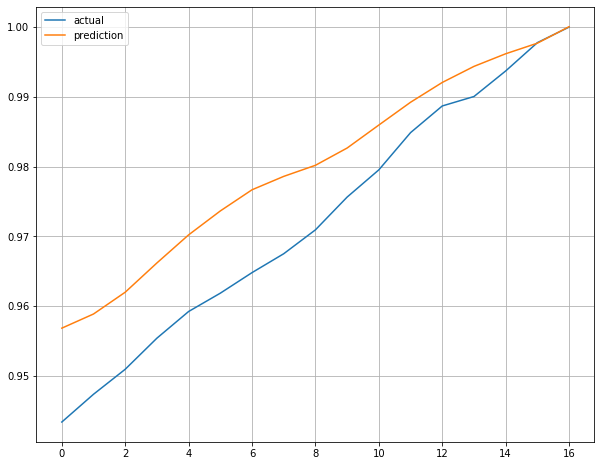

In [179]:
plt.figure(figsize=(10, 8))
plt.plot(test_label, label='actual')
plt.plot(pred, label='prediction')
plt.grid()
plt.legend()
plt.show()